In [1]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


# Importing Libraries

In [2]:
%%capture
! pip install transformers
! pip install -q datasets
! pip install tesseract-ocr
! pip install -q pytesseract
! pip install -q git+https://github.com/huggingface/transformers.git

In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
#from imutils import paths
import os
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from random import shuffle
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras import layers
import datetime
from tensorflow.keras.models import Model
from transformers import TFBertModel, BertConfig
from PIL import Image
import pytesseract
import re
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import zipfile
import tempfile
from PIL import Image #, ImageDraw, ImageFont
#from PIL import ImageOps
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english')) 
tf.test.is_gpu_available(cuda_only=True)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [4]:
base_df = pd.read_csv('../input/datathonindoml-2022/train_labels.csv')

In [5]:
base_df.label.value_counts()

8     1059
6     1044
0     1032
12    1020
5     1012
11    1011
13    1007
9     1000
3      993
14     992
15     988
10     974
1      969
2      968
4      966
7      965
Name: label, dtype: int64

In [6]:
df=pd.read_csv('../input/dataset/dataset4.csv')

In [7]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Text Preprocessing

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [9]:
token = tokenizer.encode_plus(
    df['text'].iloc[0], 
    max_length=256,
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

In [10]:
token.input_ids

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101,   187,  5871, 14791,  5108,  1419,  1107,  1665, 24613,
         1475,  2000,  1812,   185,  2884,  3236, 16480,  1571,  3987,
        10151, 16946,  1465, 22637, 23124,   185,  8613,  1186, 18783,
         5603, 18202,  4130,  2578,  1231, 18540, 22593,   128,  2236,
          123,  3641, 19220,  2965, 28112,  1571,  2848,   172, 16669,
         2116,  2578,  2587,  2616,  1703,  2616,   189,  1182,  1568,
          124,   184,  1830,  1233,   189,  1643, 16358,  1181,  9814,
          192,  7745,   171, 13840,  1182,   195,  2155,  5507,  1604,
          124,   121,  1782,   174,   184, 23249,   188,  8871,  1940,
         1195,  1197, 25338,  1233,   195,  7745,   171, 12809,   122,
          123,  5682,   170, 20153,  7231,  5507,  1604, 14162,  2393,
         1519,  3641, 24438,  1775,   189,  1183,  9304,  1358,   184,
         1162,   182,  2217,   125,   193,  1324, 27629,  1197,   176,
         1813,  1476,   175, 

In [11]:
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [14]:
def generate_training_data(df, ids, masks, tokenizer):
    i=0
    for text in tqdm(df['text']):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
        i=i+1
    return ids, masks

In [15]:
df['text'] = df['text'].fillna('empty')

In [16]:
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

  0%|          | 0/16000 [00:00<?, ?it/s]

In [17]:
labels = np.zeros((len(df), 16))
labels.shape

(16000, 16)

In [18]:
labels[np.arange(len(df)), df['label'].values] = 1 # one-hot encoded target tensor

In [19]:
labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<TakeDataset shapes: ((256,), (256,), (16,)), types: (tf.float64, tf.float64, tf.float64)>

In [21]:
def LabelDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [22]:
dataset = dataset.map(LabelDatasetMapFunction) # converting to required format for tensorflow dataset 

In [23]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (256,), attention_mask: (256,)}, (16,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [24]:
dataset = dataset.shuffle(16000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [25]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (16, 256), attention_mask: (16, 256)}, (16, 16)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

In [26]:
p = 0.8
train_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

In [27]:
train_size

800

In [28]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [29]:
from transformers import TFBertModel, BertConfig

In [30]:
with strategy.scope():
#     config = BertConfig()
#     bert_model = TFBertModel(config)
    bert_model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights
    input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
    attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

    bert_embds = bert_model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
    intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
    output_layer = tf.keras.layers.Dense(16, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes
    classification_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
    optim = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
    loss_func = tf.keras.losses.CategoricalCrossentropy()
    acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
    classification_model.compile(optimizer=optim, loss=loss_func, metrics=[acc, get_f1])

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [31]:
history_bert = classification_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15
)

Epoch 1/25
800/800 [==============================] - 430s 525ms/step - loss: 1.5776 - accuracy: 0.5239 - get_f1: 0.3827 - val_loss: 1.0266 - val_accuracy: 0.6903 - val_get_f1: 0.6719
Epoch 2/25
800/800 [==============================] - 418s 523ms/step - loss: 0.9779 - accuracy: 0.7030 - get_f1: 0.6878 - val_loss: 0.7936 - val_accuracy: 0.7619 - val_get_f1: 0.7554
Epoch 3/25
800/800 [==============================] - 419s 523ms/step - loss: 0.8073 - accuracy: 0.7583 - get_f1: 0.7550 - val_loss: 0.6364 - val_accuracy: 0.8119 - val_get_f1: 0.8103
Epoch 4/25
800/800 [==============================] - 418s 523ms/step - loss: 0.6602 - accuracy: 0.8027 - get_f1: 0.8010 - val_loss: 0.4400 - val_accuracy: 0.8722 - val_get_f1: 0.8780
Epoch 5/25
800/800 [==============================] - 418s 523ms/step - loss: 0.5579 - accuracy: 0.8355 - get_f1: 0.8353 - val_loss: 0.3880 - val_accuracy: 0.8941 - val_get_f1: 0.8956
Epoch 6/25
800/800 [==============================] - 418s 523ms/step - loss: 0.

KeyboardInterrupt: 

# Efficientnet Model

In [ ]:
# df_img=df.sample(frac=1)

In [32]:
df_img=df

In [33]:
df_img['label']= df_img['label'].map(str)

In [34]:
df_img.head()

,id,label,address,text
0,0,1,0.tif,r harritan company inc 2541 space road p box 3...
1,1,13,1.tif,sgent k group ltd 209e4e9230 05 22 00 8 44 job...
2,2,13,2.tif,ome testing nate pea dsegad number 4 hay ate a...
3,3,14,3.tif,por application research clinical investigatio...
4,4,6,4.tif,seyusey ysa aqeq 404 u6y sey sdip yoicain ane ...


In [35]:
df_img=df_img.drop(['text'], axis=1)
df_img.head()

,id,label,address
0,0,1,0.tif
1,1,13,1.tif
2,2,13,2.tif
3,3,14,3.tif
4,4,6,4.tif


In [36]:
labels_cnn=df_img.label.unique()
labels_cnn

array(['1', '13', '14', '6', '11', '4', '2', '8', '9', '10', '12', '15',
       '3', '5', '7', '0'], dtype=object)

In [37]:
df_img.head()

,id,label,address
0,0,1,0.tif
1,1,13,1.tif
2,2,13,2.tif
3,3,14,3.tif
4,4,6,4.tif


In [38]:
classes=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15']

In [62]:
dataset = 'train/train/'
#val_dataset = './datathonindoml-2022/validation/validation/'

datagen = ImageDataGenerator(
      rescale= 1 / 255.0,
      validation_split=0.20,
#       samplewise_center=True,
#       samplewise_std_normalization= True,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       fill_mode='nearest',
)

# full_datagen = ImageDataGenerator(
#       rescale= 1 / 255.0,
#       samplewise_center=True,
#       samplewise_std_normalization= True,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       fill_mode='nearest'
# )

# NOTE: YOU MUST USE A BATCH SIZE OF 10 (batch_size=10) FOR THE 

train_generator=datagen.flow_from_dataframe(
dataframe=df_img,
classes=classes,
directory="../input/datathonindoml-2022/train/train",
x_col="address",
y_col="label",
subset="training",
batch_size=64,
class_mode="categorical",
target_size=(224,224))

valid_generator=datagen.flow_from_dataframe(
dataframe=df_img,
classes=classes,
directory="../input/datathonindoml-2022/train/train",
x_col="address",
y_col="label",
subset="validation",
batch_size=64,
class_mode="categorical",
target_size=(224,224))

Found 12800 validated image filenames belonging to 16 classes.
Found 3200 validated image filenames belonging to 16 classes.


In [63]:
x,y = next(train_generator)
x.shape

(64, 224, 224, 3)

In [64]:
train_generator.class_indices

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '2': 8,
 '3': 9,
 '4': 10,
 '5': 11,
 '6': 12,
 '7': 13,
 '8': 14,
 '9': 15}

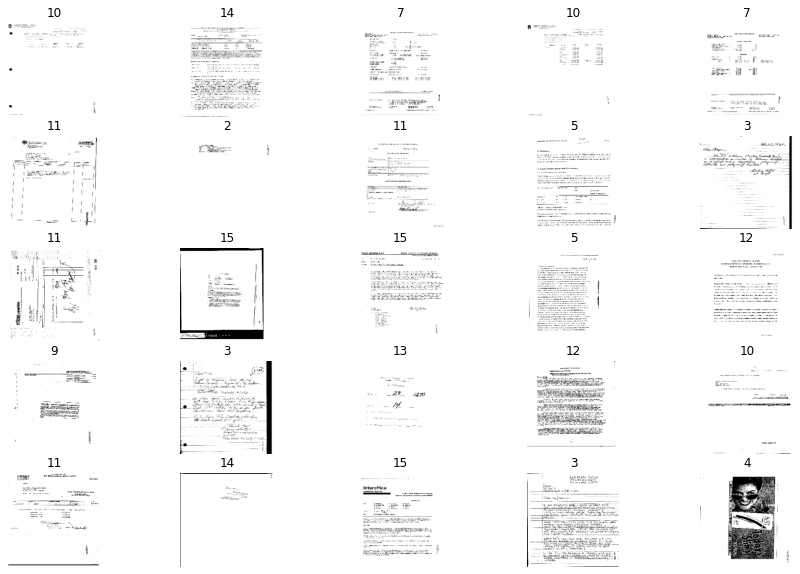

In [65]:
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list
def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
        
plot_images(x,y)

In [66]:
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

In [67]:
def create_model(model_url,num_classes=16):
    feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))
    model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer')])

    return model

In [68]:
efficient_net = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
resnet = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
inceptionnet = 'https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5'

In [69]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [70]:
import tensorflow
model = create_model(efficient_net,
                            num_classes=16)
# resnet_model.summary()
model.compile(loss='categorical_crossentropy',
                     optimizer=tensorflow.keras.optimizers.Adam(learning_rate=3e-4),
                     metrics=['accuracy', get_f1])

In [71]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 16)                20496     
Total params: 4,070,060
Trainable params: 20,496
Non-trainable params: 4,049,564
_________________________________________________________________


In [72]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20)

Epoch 1/20
200/200 [==============================] - 72s 324ms/step - loss: 2.2482 - accuracy: 0.3638 - get_f1: 0.0418 - val_loss: 1.9032 - val_accuracy: 0.4806 - val_get_f1: 0.1404
Epoch 2/20
200/200 [==============================] - 59s 296ms/step - loss: 1.7597 - accuracy: 0.5054 - get_f1: 0.2495 - val_loss: 1.6769 - val_accuracy: 0.5225 - val_get_f1: 0.3238
Epoch 3/20
200/200 [==============================] - 59s 293ms/step - loss: 1.6042 - accuracy: 0.5377 - get_f1: 0.3530 - val_loss: 1.5783 - val_accuracy: 0.5403 - val_get_f1: 0.3917
Epoch 4/20
200/200 [==============================] - 60s 300ms/step - loss: 1.5210 - accuracy: 0.5549 - get_f1: 0.4059 - val_loss: 1.5198 - val_accuracy: 0.5497 - val_get_f1: 0.4366
Epoch 5/20
200/200 [==============================] - 60s 300ms/step - loss: 1.4654 - accuracy: 0.5667 - get_f1: 0.4382 - val_loss: 1.4753 - val_accuracy: 0.5603 - val_get_f1: 0.4544
Epoch 6/20
200/200 [==============================] - 56s 282ms/step - loss: 1.4209 -

In [61]:
classification_model.save('bert.h5')

In [73]:
model.save('eff_model.h5')

In [75]:
model=tf.keras.models.load_model('/kaggle/working/eff_model.h5', custom_objects={'KerasLayer':hub.KerasLayer,'get_f1':get_f1})

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.6524999737739563\nValidation Accuracy: 0.6243749856948853')

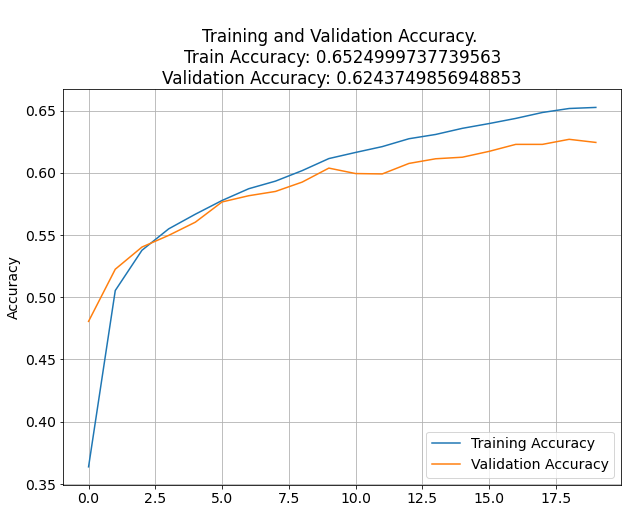

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

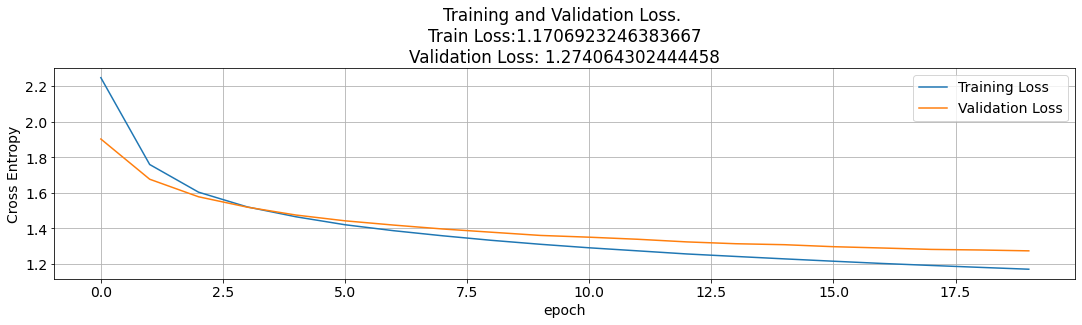

In [77]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss:{str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

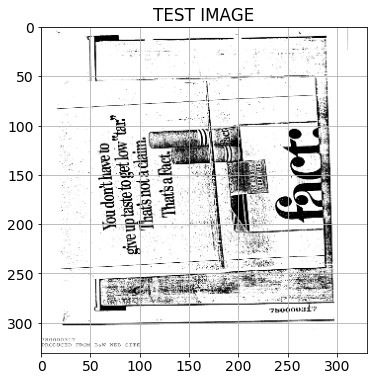

In [78]:
test_img_path = "../input/datathonindoml-2022/validation/validation/17801.tif"
img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (331, 331)).reshape(-1, 331, 331, 3)/255
plt.figure(figsize=(6,6))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])

In [79]:
test_path='../input/datathonindoml-2022/train/train'

In [80]:
class_dict = {v: k for k, v in a.items()}
class_dict

{0: '0',
 1: '1',
 2: '10',
 3: '11',
 4: '12',
 5: '13',
 6: '14',
 7: '15',
 8: '2',
 9: '3',
 10: '4',
 11: '5',
 12: '6',
 13: '7',
 14: '8',
 15: '9'}

In [93]:
df_w=df.tail(2000)
df_w.head()

,id,label,address,text
14000,14000,14,14000.tif,rc appendix three curriculum vitae ecozilvezos
14001,14001,4,14001.tif,52629 0704 boo ee le b e
14002,14002,12,14002.tif,revised draft 11 3 93 jgr draft bllen merlo tr...
14003,14003,14,14003.tif,ff principat investigatorprogram director last...
14004,14004,11,14004.tif,ss healthy building tnucri uation ie om itt co...


In [94]:
cnn_labels = np.zeros((len(df_w), 16))

In [95]:
cnn_labels.shape

(2000, 16)

In [96]:
img = tf.keras.preprocessing.image.load_img(test_path +'/'+ '800.tif')
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.keras.preprocessing.image.smart_resize(img, (224, 224))
img = tf.reshape(img, (-1, 224, 224, 3))
prediction = model.predict(img/255)
prediction[0]

array([0.00174432, 0.0307147 , 0.04417815, 0.01270719, 0.00998846,
       0.64395946, 0.05409326, 0.01109358, 0.00371695, 0.00243542,
       0.00500287, 0.02535109, 0.00585728, 0.12635162, 0.00324379,
       0.0195618 ], dtype=float32)

In [97]:
cnn_pred_probs=[]
predictions = []
k=0

In [98]:
for image in tqdm(df_w.address):
    img = tf.keras.preprocessing.image.load_img(test_path +'/'+ image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (224, 224))
    img = tf.reshape(img, (-1, 224, 224, 3))
    prediction = model.predict(img/255)
    cnn_pred_probs.append(prediction)
    for p in range(16):
        cnn_labels[k][p]=prediction[0][int(class_dict[p])]
#     cnn_labels[k]=prediction
    k=k+1
    x=np.argmax(prediction)
    predictions.append(class_dict[x])

  0%|          | 0/2000 [00:00<?, ?it/s]

In [99]:
cnn_labels[:5]

array([[2.62862095e-03, 6.31257473e-03, 4.18642303e-03, 2.09224477e-01,
        2.10375129e-03, 1.54587836e-03, 2.38611177e-01, 8.66603572e-03,
        2.02723816e-02, 3.89741291e-03, 4.34568137e-01, 4.86623496e-02,
        7.79213523e-03, 5.75394183e-03, 1.47800217e-03, 4.29667905e-03],
       [3.08637565e-04, 9.29603586e-04, 2.37153843e-03, 4.62862954e-05,
        1.33726455e-04, 4.90147286e-05, 3.66545864e-04, 3.03548790e-04,
        1.54402165e-04, 9.00844636e-04, 4.26988408e-05, 7.97203757e-05,
        4.37228417e-04, 5.26472519e-04, 6.89199369e-04, 9.92660522e-01],
       [3.58096771e-02, 2.93732411e-03, 4.40476788e-03, 1.28308281e-01,
        1.53630450e-02, 7.88715668e-03, 2.50322453e-04, 3.59095149e-02,
        4.65767179e-03, 4.71677195e-04, 5.69131792e-01, 3.59976925e-02,
        7.69573078e-02, 6.11525141e-02, 1.54232327e-02, 5.33804577e-03],
       [3.03568598e-02, 2.17569321e-02, 5.25575783e-03, 2.44455356e-02,
        1.52780963e-02, 2.01353971e-02, 8.32458391e-05, 1.293

In [100]:
arr = df_w["label"].to_numpy()
from array import *
arrL = arr.tolist()

In [101]:
count=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
score={
    0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0,15:0
}
for i in range(2000):
    count[int(arrL[i])]=count[int(arrL[i])]+1
    if(arrL[i]==predictions[i]):
        score[int(arrL[i])]=score[int(arrL[i])]+1

0
1000


In [102]:
final_class_preds=[]
for k in range(16):
    final_class_preds.append(score[k]/count[k])
for j,k in enumerate(final_class_preds):
    print(j, k)

0 0.4056603773584906
1 0.41379310344827586
2 0.7777777777777778
3 0.7903225806451613
4 0.7903225806451613
5 0.24812030075187969
6 0.7633587786259542
7 0.652542372881356
8 0.9513888888888888
9 0.7909090909090909
10 0.45454545454545453
11 0.5153846153846153
12 0.7086614173228346
13 0.5378787878787878
14 0.7803030303030303
15 0.30434782608695654


# bert

In [104]:
bert_model=tf.keras.models.load_model('/kaggle/working/bert.h5', custom_objects={'KerasLayer':hub.KerasLayer,'get_f1':get_f1})
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def prepare_image_data(address):
    im = cv2.imread(f"validation/validation/{address}")
    im = cv2.resize(im, (224, 224),
               interpolation = cv2.INTER_NEAREST)
    return im

In [112]:
df_w = df.tail(2000)
df_w['text'] = df_w['text'].fillna('empty')
bert_pred_probs=[]
pred_results=[]
for i in tqdm(df_w.text):        
    processed_data = prepare_data(i, tokenizer)
    bert_probs = classification_model.predict(processed_data)[0]
#     bert_pred_probs.append(bert_probs)
    res=np.argmax(bert_probs)
    bert_pred_probs.append(bert_probs)
    pred_results.append(res)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


  0%|          | 0/2000 [00:00<?, ?it/s]

In [113]:
arr = df_w["label"].to_numpy()
arrL = arr.tolist()
arrL = [int(i) for i in arrL]
arrL[:20]

[14, 4, 12, 14, 11, 2, 5, 11, 0, 9, 11, 4, 3, 2, 8, 13, 0, 2, 0, 3]

In [114]:
count=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
score={
    0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0,15:0
}
for i in range(2000):
    count[arrL[i]]=count[arrL[i]]+1
    if(int(arrL[i])==pred_results[i]):
        score[int(arrL[i])]=score[int(arrL[i])]+1

In [115]:
final_class_preds2=[]
for k in range(16):
    final_class_preds2.append(score[k]/count[k])
for j,k in enumerate(final_class_preds2):
    print(j, k)

0 0.9622641509433962
1 0.9741379310344828
2 1.0
3 0.9838709677419355
4 0.967741935483871
5 1.0
6 0.9923664122137404
7 1.0
8 0.8958333333333334
9 0.9636363636363636
10 0.9772727272727273
11 0.9923076923076923
12 0.9921259842519685
13 0.9924242424242424
14 0.9848484848484849
15 1.0


In [116]:
for j,k in enumerate(final_class_preds):
    print(j, k)

0 0.4056603773584906
1 0.41379310344827586
2 0.7777777777777778
3 0.7903225806451613
4 0.7903225806451613
5 0.24812030075187969
6 0.7633587786259542
7 0.652542372881356
8 0.9513888888888888
9 0.7909090909090909
10 0.45454545454545453
11 0.5153846153846153
12 0.7086614173228346
13 0.5378787878787878
14 0.7803030303030303
15 0.30434782608695654
